In [33]:
import earthpy.spatial as es
import os, sys
from glob import glob
import rasterio as rio
import matplotlib.pyplot as plt
import rasterstats
import geopandas as gpd
import pandas as pd
from rasterio.plot import show, reshape_as_image
import numpy as np
from matplotlib.animation import FuncAnimation

In [5]:
images = glob(os.path.join('./data_collated',"**/*WATER_MASKED.tif"), recursive = True)

images

['./data_collated\\2013\\2013_WATER_MASKED.tif',
 './data_collated\\2014\\2014_WATER_MASKED.tif',
 './data_collated\\2015\\2015_WATER_MASKED.tif',
 './data_collated\\2016\\2016_WATER_MASKED.tif',
 './data_collated\\2017\\2017_WATER_MASKED.tif',
 './data_collated\\2018\\2018_WATER_MASKED.tif',
 './data_collated\\2019\\2019_WATER_MASKED.tif',
 './data_collated\\2020\\2020_WATER_MASKED.tif',
 './data_collated\\2021\\2021_WATER_MASKED.tif',
 './data_collated\\2022\\2022_WATER_MASKED.tif']

In [22]:
ndvi_dict = {}
years = [str(year) for year in range(2013,2023)]

for idx, image in enumerate(images):
    with rio.open(image) as src:
        # import red and nir bands
        nir = src.read(5, masked = True)
        red = src.read(4, masked = True)
    src.close()

    # Adjust to reflectance using the given scale factors; see document below
    # https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf
    nir = nir * 0.0000275 + -0.2
    red = red * 0.0000275 + -0.2

    # ndvi calculation
    ndvi = (nir - red) / (nir + red)

    # Landsat 8 Level 2 products have an issue where water can result in negative reflectance
    # in such cases, set NDVI to -1
    ndvi[(nir < 0) | (red < 0)] = -1
    
    # Append raster to dictionary
    ndvi_dict[years[idx]] = ndvi

In [23]:
ndvi_dict

{'2013': masked_array(
   data=[[0.29939189553260803, 0.24800609052181244, 0.25450772047042847,
          ..., 0.8395271897315979, 0.8151180744171143, 0.7120533585548401],
         [0.30951499938964844, 0.32823339104652405, 0.3376455307006836,
          ..., 0.9377093315124512, 0.7714939117431641, 0.5804723501205444],
         [-0.06611891835927963, 0.1955541968345642, 0.3334633708000183,
          ..., -1.0, 0.5747003555297852, 0.400467187166214],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., 0.9763835072517395, 0.9755796194076538,
          0.8857325315475464],
         [--, --, --, ..., -1.0, 0.9768600463867188, 0.6834847331047058]],
   mask=[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ..., False, False, False],
         [ True,

CPU times: total: 15.1 s
Wall time: 15.1 s


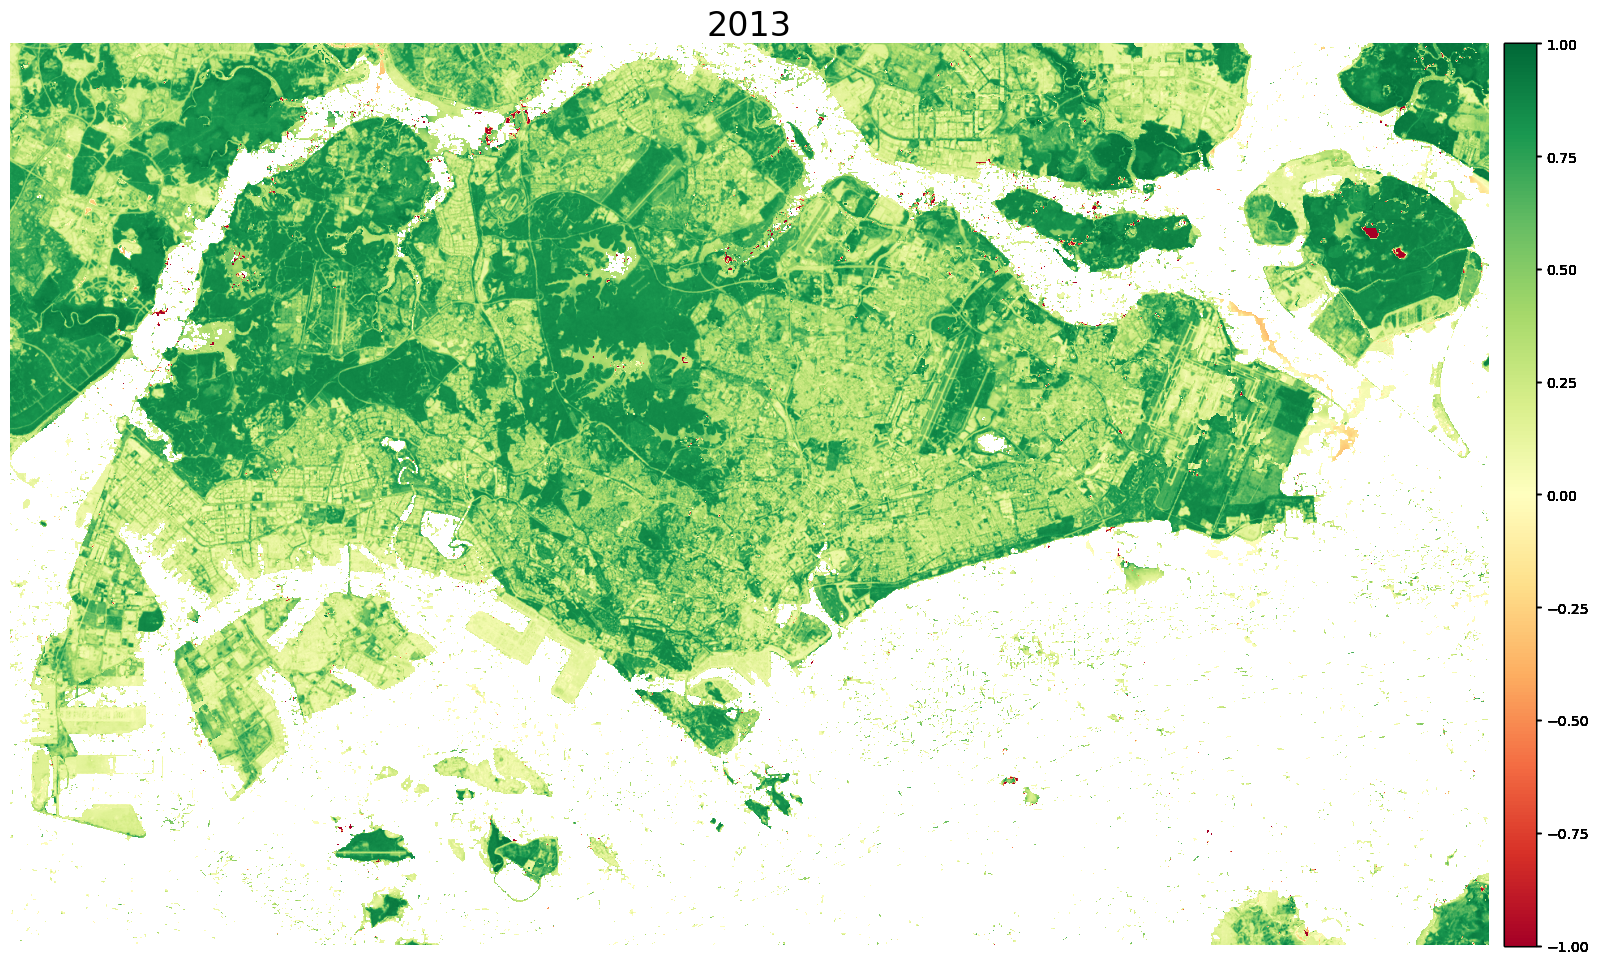

In [57]:
%%time
fig, ax = plt.subplots(figsize = (16,12))
ax.axis("off")

# This creates a colorbar that will stay on the animation
# Adds axes with the following arguments: left bottom width height
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

vmin = -1
vmax = 1

# # This creates a colorbar that will stay on the animation
# # Adds axes with the following arguments: left bottom width height
# cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
# sm = plt.cm.ScalarMappable(cmap = "RdYlGn", norm=plt.Normalize(vmin = -0.5, vmax = 1))
# # fake up the array of the scalar mappable. Urgh...
# sm._A = []
# fig.colorbar(sm, cax=cax)

def update(frame):
    year = years[frame]
    
    im = ax.imshow(ndvi_dict[year], cmap = "RdYlGn", vmin = vmin, vmax = vmax)
    
    ax.set_title(f"{year}", fontsize = 24)
    
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    
    fig.colorbar(im, cax=cax)
    
animation = FuncAnimation(fig, update, frames=len(years), repeat=True, interval = 1000)

plt.subplots_adjust(
    top=0.91,
    bottom=0.02,
    left=0.008,
    right=0.932,
    hspace=0.2,
    wspace=0.2
)

# Save the animation
animation_file = f'singapore_ndvi_postmosaic_animation.gif'
animation.save(animation_file, writer='pillow')

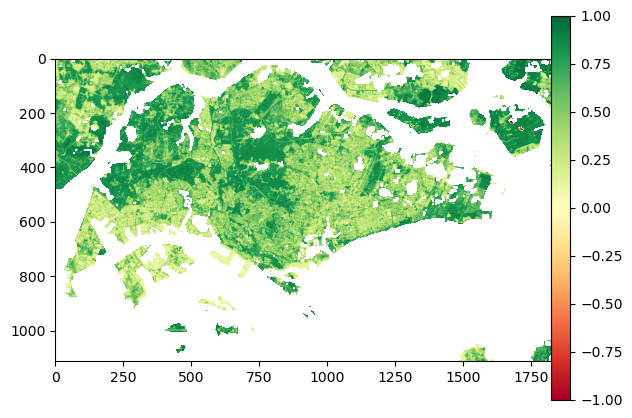

In [31]:
fig, ax = plt.subplots()

cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap = "RdYlGn", norm=plt.Normalize(vmin = -1, vmax = 1))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
fig.colorbar(sm, cax=cax)

im = show(ndvi_dict['2013'], cmap = "RdYlGn", ax = ax)